In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import os
from tqdm import tqdm
from time import time
from IPython import display

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print(tf.__version__)
print(gpus)

2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [3]:
# set visible devices
tf.config.experimental.set_visible_devices(gpus[2], 'GPU')

## load data </br>
We generated spin grid data with Ising model using Monte Carlo Simulation - Metropolis algorithm. </br>
It was simulated 10000 MC times and used steady state spin grid data from 9000 to end.

In [4]:
def load_spin_data(fname):
    with open(fname, "rb") as fid:
        tmp_spins = pkl.load(fid)
        # (nitr, t, spin_x, spin_y)
        spins = tmp_spins[0]
        for i in range(1, 5):
            spins = np.concatenate((spins, tmp_spins[i]))
    return spins

In [5]:
# file names
fdir = '../data/'
fnames = os.listdir(fdir)

# Temperature: 1.5 - 3.5
T = 1.5
Tend = 3.5

NUM_T = int((Tend-T)/0.1+1)
Ts = np.linspace(T, Tend, NUM_T)
NUM_SPINS = 5000
LEN_SPIN = 100
BUFFER_SIZE = NUM_SPINS * NUM_T

# load data
spins = load_spin_data(os.path.join(fdir, "spins_%.2f.pkl"%(T)))
spin_labels = np.zeros([NUM_SPINS*NUM_T, NUM_T])
spin_labels[:NUM_SPINS, 0] = 1
for i in tqdm(range(1, NUM_T)):
    T = np.round(T + 0.1, 1)
    tmp_spins = load_spin_data(os.path.join(fdir, "spins_%.2f.pkl"%(T)))
    spins = np.concatenate((spins, tmp_spins))
    spin_labels[(i*NUM_SPINS):((i+1)*NUM_SPINS), i] = 1

# convert data type
spins = spins.reshape(NUM_SPINS*NUM_T, LEN_SPIN, LEN_SPIN, 1)
spins = spins.astype('float32')
spin_labels = spin_labels.astype('float32')

100%|██████████| 20/20 [02:12<00:00,  6.61s/it]


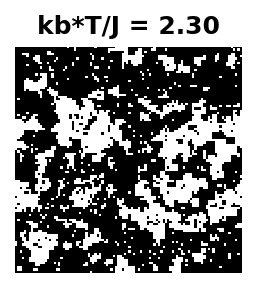

In [6]:
# show example data
n = 40000

plt.figure(dpi=150, figsize=(2, 2))
plt.imshow(spins[n][:, :, 0], cmap='gray')
plt.title("kb*T/J = %.2f"%(Ts[n//NUM_SPINS]), fontweight='bold')
plt.axis('off')
plt.show()

In [7]:
# shuffle & seperate data as batches
BATCH_SIZE = 256
train_set = tf.data.Dataset.from_tensor_slices((spins, spin_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_set)

<BatchDataset shapes: ((None, 100, 100, 1), (None, 21)), types: (tf.float32, tf.float32)>


## create conditional GAN model

<img src="https://blog.kakaocdn.net/dn/T29ar/btqGWTZBAFh/n9UkGAKfukrLtkxkCfFXSK/img.png" width="300" height="300">

### create generator & discriminator

In [8]:
SIZE_NOISE = 1000

In [9]:
def make_generator_model(): # corrspond to the G in the model
    
    # noisy input
    input_z = layers.Input(shape=(SIZE_NOISE,), name='gen_input_noise')
    z = layers.Dense(100*100*64, use_bias=False)(input_z)
    z = layers.BatchNormalization()(z)
    z = layers.LeakyReLU()(z)
    z = layers.Reshape((100, 100, 64))(z)
    
    # label input
    input_c = layers.Input(shape=(NUM_T,), name='gen_input_label')
    c = layers.Dense(100*100*64, use_bias=False)(input_c)
    c = layers.BatchNormalization()(c)
    c = layers.LeakyReLU()(c)
    c = layers.Reshape((100, 100, 64))(c)
        
    # concat noise & label layers - (100, 100, ?)
    zc = layers.concatenate([z, c], name='concat_gen') # (None, 7, 7, 512)
    # 1st conv2d layer - shrink, (100, 100)
    zc = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(zc)
    zc = layers.BatchNormalization()(zc)
    zc = layers.LeakyReLU()(zc)
    # 2nd conv2d layer - shrink, (50, 50)
    zc = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(zc)
    zc = layers.BatchNormalization()(zc)
    zc = layers.LeakyReLU()(zc)
    # 3rd conv2d layer - shrink, (25, 25)
    zc = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(zc)
    zc = layers.BatchNormalization()(zc)
    zc = layers.LeakyReLU()(zc)
    # middle conv2d layer - shrink, (5, 5)
    zc = layers.Conv2D(64, (5, 5), strides=(5, 5), padding='same', use_bias=False)(zc)
    zc = layers.BatchNormalization()(zc)
    zc = layers.LeakyReLU()(zc)
#     # middle conv2d layer - shrink, (5, 5)
#     zc = layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(zc)
#     zc = layers.BatchNormalization()(zc)
#     zc = layers.LeakyReLU()(zc)
    # 1st conv2d layer - increase, (25, 25)
    zc = layers.Conv2DTranspose(64, (5, 5), strides=(5, 5), padding='same', use_bias=False)(zc)
    zc = layers.BatchNormalization()(zc)
    zc = layers.LeakyReLU()(zc)
    # 2nd conv2d layer - increase, (50, 50)
    zc = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(zc)
    zc = layers.BatchNormalization()(zc)
    zc = layers.LeakyReLU()(zc)
    # 3rd output layer - increase, (100, 100)
    zc = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(zc)
    
    model = tf.keras.Model(inputs=[input_z, input_c], outputs=zc)
    assert model.output_shape == (None, LEN_SPIN, LEN_SPIN, 1)
    
    return model


def make_discriminator_model(): # corrspond to the D in the model
    
    # image input: x
    input_z = layers.Input(shape=(LEN_SPIN, LEN_SPIN, 1), name='disc_input_image') # image input
    # 1st, conv2d (50, 50)
    z = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_z)
    z = layers.LeakyReLU()(z)
    z = layers.Dropout(0.3)(z)
    # 2nd, conv2d (25, 25)
    z = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(z) # (56, 56, 16)
    z = layers.LeakyReLU()(z)
    z = layers.Dropout(0.3)(z)
    
    # label input
    input_c = layers.Input(shape=(NUM_T,), name='disc_input_noise')
    c = layers.Dense(1024)(input_c)
    c = layers.LeakyReLU()(c)
    # FC layer
    c = tf.keras.layers.Dense(25*25*128)(c)
    c = tf.keras.layers.LeakyReLU()(c)
    c = tf.keras.layers.BatchNormalization()(c)
    
    reshape_c = layers.Reshape((25, 25, 128))(c)
    
    # concat image & noise layers - (25, 25, 256)
    zc = layers.concatenate([z, reshape_c], name='concat_disc')
    # (25, 25, 256)
    zc = layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same')(zc)
    zc = layers.BatchNormalization()(zc)
    zc = layers.LeakyReLU()(zc)
    # (5, 5, 64)
    zc = layers.Conv2D(64, (5, 5), strides=(5, 5), padding='same')(zc)
    zc = layers.BatchNormalization()(zc)
    zc = layers.LeakyReLU()(zc)
    # discriminate image
    zc = layers.Flatten()(zc)
    zc = layers.Dense(1024)(zc)
    zc = layers.LeakyReLU()(zc)
    zc = layers.Dense(1)(zc)
    
    model = tf.keras.Model(inputs=[input_z, input_c], outputs=zc)

    return model

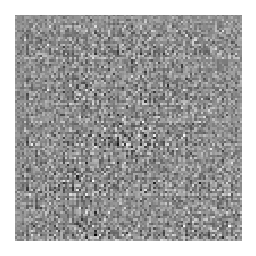

tf.Tensor([[0.00184093]], shape=(1, 1), dtype=float32)


In [10]:
# Test with non trained model
test_noise = tf.random.normal([1, SIZE_NOISE])
test_label = np.zeros([1, NUM_T], dtype=np.float32); test_label[0, 0] = 1

# generator
generator = make_generator_model()
generated_image = generator([test_noise, test_label], training=False)

# discriminator
discriminator = make_discriminator_model()
decision = discriminator([generated_image, test_label])

plt.figure(dpi=150, figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

print(decision)

### loss function

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(real_output), real_output)
    fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(fake_output), fake_output)

In [12]:
learning_rate = 1e-4
# generator and discriminator optimize each other
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [13]:
checkpoint_dir = './training_checkpoints_cGAN_ising/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training

In [14]:
EPOCHS = 20
num_examples_to_generate = NUM_T

test_seed = tf.random.normal([num_examples_to_generate, SIZE_NOISE])
test_labels = np.zeros([num_examples_to_generate, NUM_T], dtype=np.float32)
for i in range(num_examples_to_generate):
    test_labels[i, i] = 1

In [15]:
@tf.function
def train_step(data):
    noise = tf.random.normal([data[0].shape[0], SIZE_NOISE])

    with tf.GradientTape(persistent=True) as g:
        # real image
        real_output = discriminator(data, training=True)
        # fake iamge
        generated_image = generator((noise, data[1]), training=True)
        fake_output = discriminator((generated_image, data[1]), training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    grad_of_generator = g.gradient(gen_loss, generator.trainable_variables)
    grad_of_discriminator = g.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_of_discriminator, discriminator.trainable_variables))

    
def train(dataset, epochs):
    
    generate_and_save_images(generator, 0, (test_seed, test_labels))
    for epoch in range(epochs):
        start = time()
        for data_batch in dataset:
            train_step(data_batch)
            
        # Create imae
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, (test_seed, test_labels))
        
        print("time for epochs %d is %.2f sec"%(epoch+1, time()-start))
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, (test_seed, test_labels))

    
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    plt.figure(dpi=300, figsize=(18, 8))

    for i in range(21):
        plt.subplot(3, 7, i+1)

        im = np.array(predictions[i, :, :, 0])
        im[im > 0] = 1
        im[im < 0] = -1

        plt.axis('off')
        plt.imshow(im, cmap='gray')
        plt.title(r'$k_{b}$T/J=%.2f'%(1.5+i*0.1))
        
    plt.savefig('./cGAN_ising/%04d.png'%(epoch))
    plt.show()

In [16]:
generator = make_generator_model()
discriminator = make_discriminator_model()

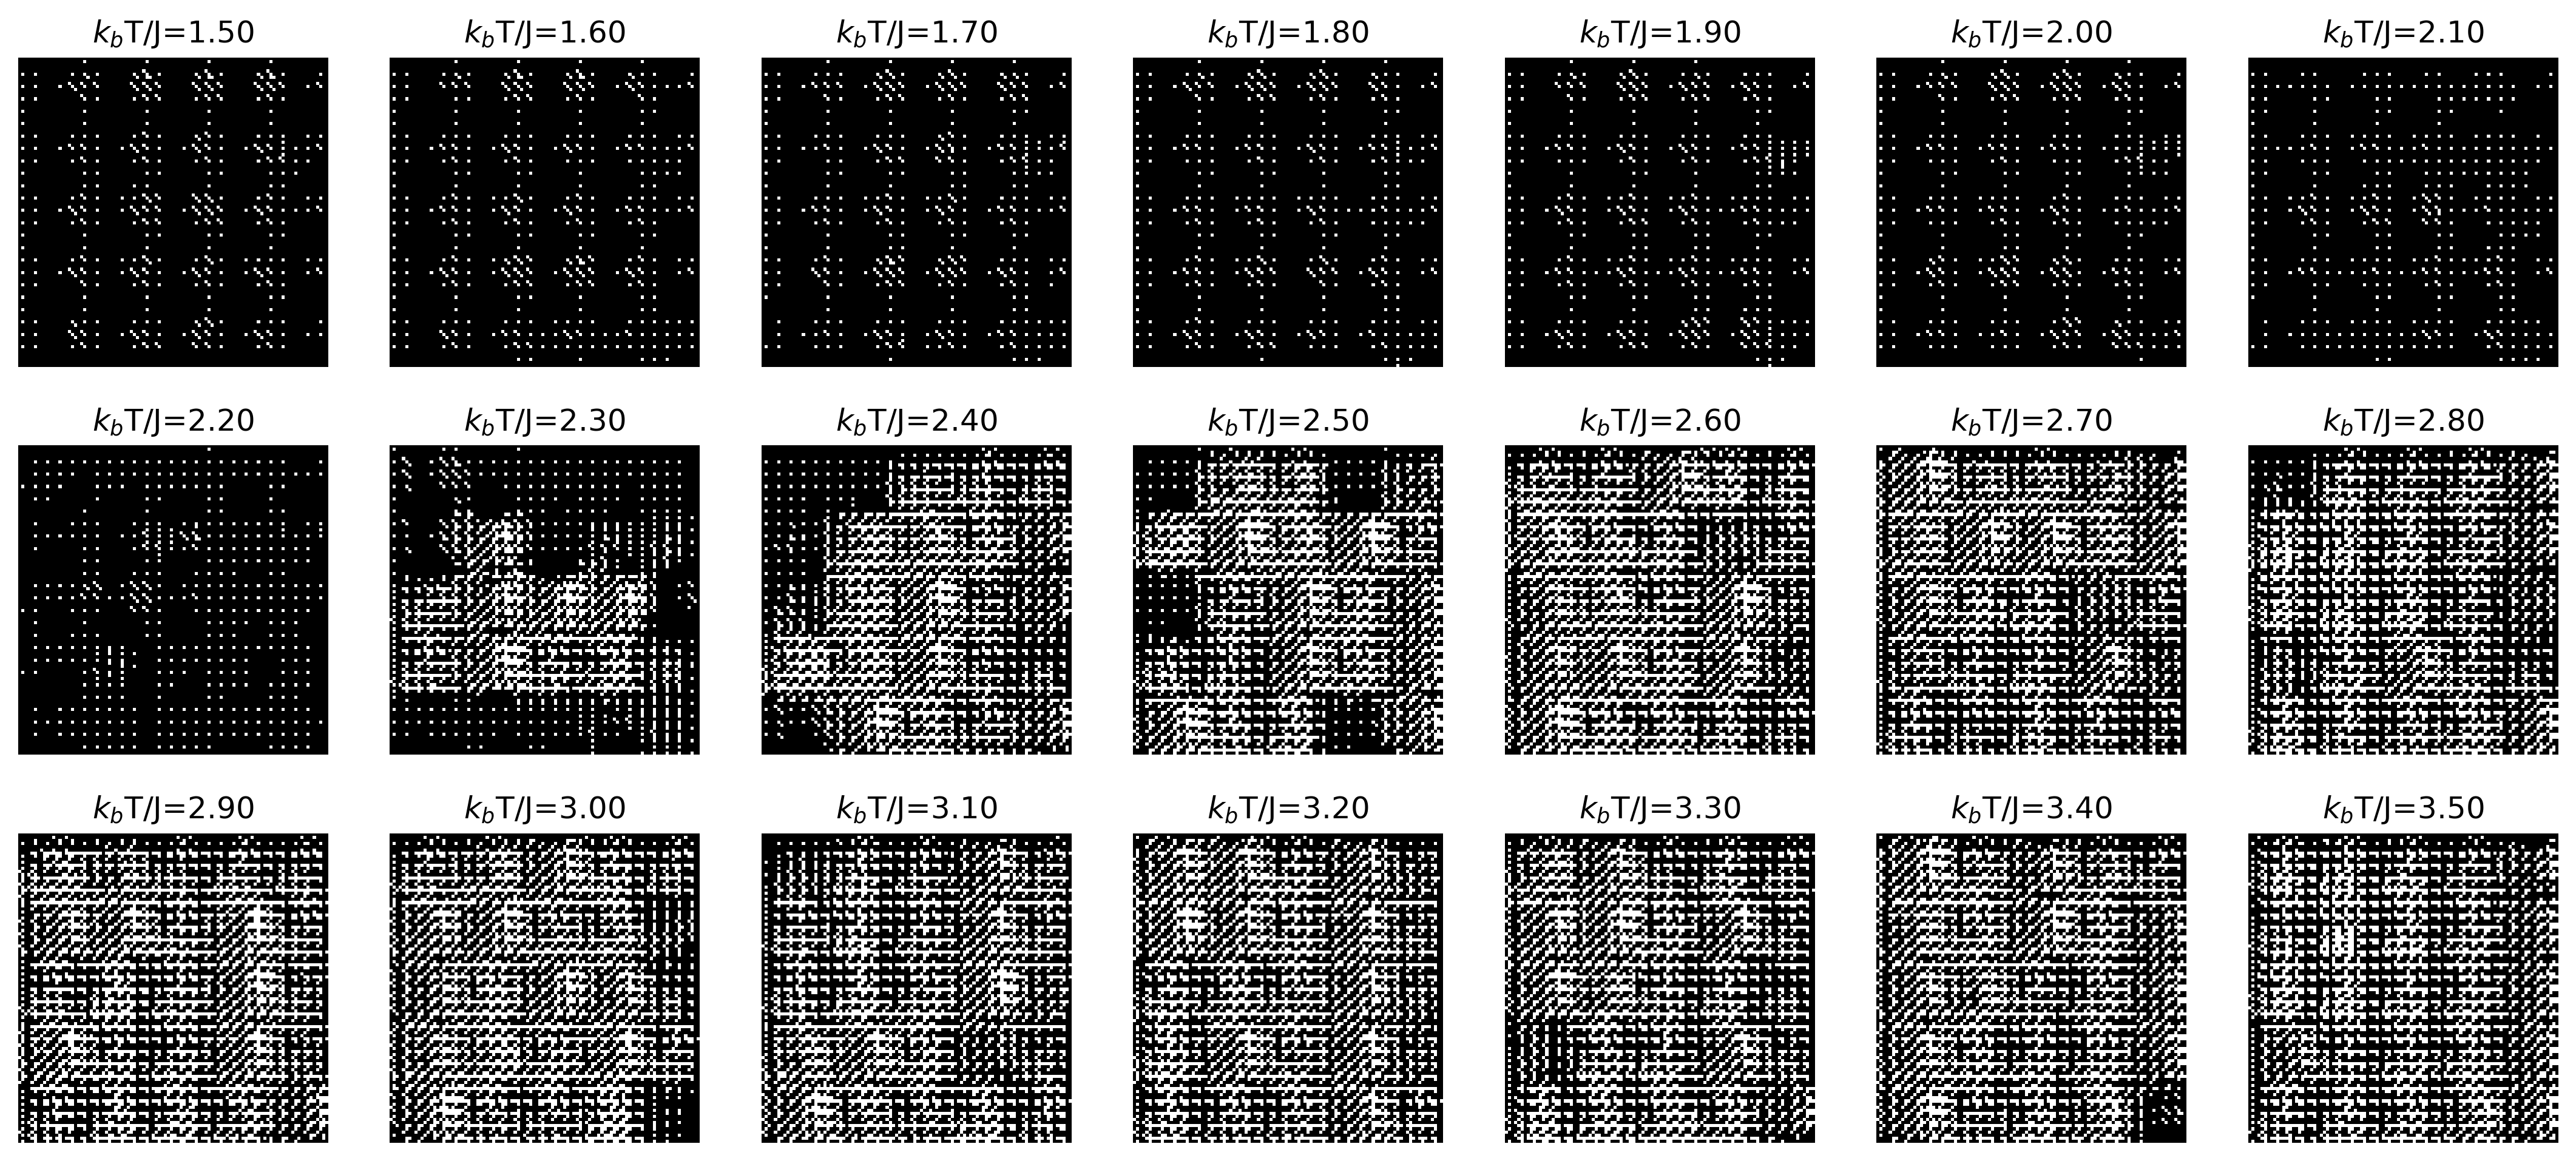

time for epochs 1 is 302.11 sec


In [ ]:
train(train_set, EPOCHS)

In [19]:
display.clear_output()

In [20]:
discriminator.save('./training_model_cGAN_ising/disc')
generator.save('./training_model_cGAN_ising/gen')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./training_model_cGAN_ising/disc/assets
INFO:tensorflow:Assets written to: ./training_model_cGAN_ising/gen/assets


## print to animation

In [21]:
import imageio
import glob

In [24]:
fanim = 'cGAN_ising/cgan_ising.gif'

with imageio.get_writer(fanim, mode='I', fps=10) as writer:
    fnames = glob.glob('./cGAN_ising/*.png')
    fnames = sorted(fnames)
    last = -1
    
    for i, fname in enumerate(fnames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        im = imageio.imread(fname)
        writer.append_data(im)
    im = imageio.imread(fname)
    writer.append_data(im)

## Get Ising map

In [84]:
n_samples = 1000
target_seeds = tf.random.normal([NUM_T*n_samples, SIZE_NOISE])
target_labels = np.zeros([NUM_T*n_samples, NUM_T], dtype=np.float32)

for i in range(NUM_T):
    for j in range(n_samples):
        target_labels[i*n_samples+j, i] = 1

In [85]:
spins = generator.predict([target_seeds, target_labels])

In [86]:
mags = []
suss = []

for i in range(NUM_T):
    mag = 0
    r2s = 0
    for j in range(n_samples):
        mag += abs(np.average(spins[i*n_samples+j, :, :, 0]))
        r2s += np.average(spins[i*n_samples+j, :, :, 0])**2
    
    mags.append(mag/n_samples)
    sus = (r2s/n_samples - mags[i]**2) * n_samples
    suss.append(sus)
    

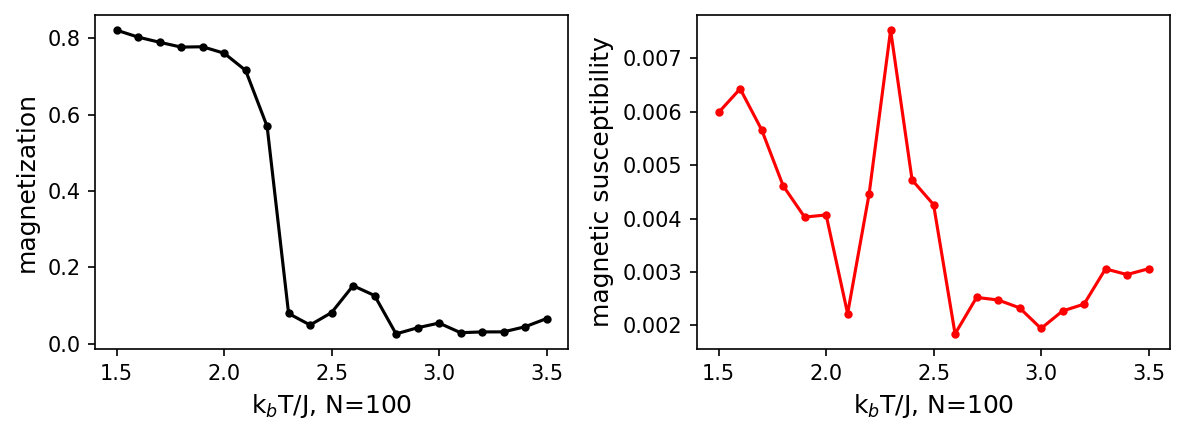

In [83]:
plt.figure(dpi=150, figsize=(8, 3))

plt.subplot(121)
plt.plot(np.linspace(1.5, 3.5, NUM_T), mags, 'k.-')
plt.xlabel(r'k$_{b}$T/J, N=100', fontsize=12)
plt.ylabel('magnetization', fontsize=12)

plt.subplot(122)
plt.plot(np.linspace(1.5, 3.5, NUM_T), suss, 'r.-')
plt.xlabel(r'k$_{b}$T/J, N=100', fontsize=12)
plt.ylabel('magnetic susceptibility', fontsize=12)

plt.tight_layout()
plt.show()

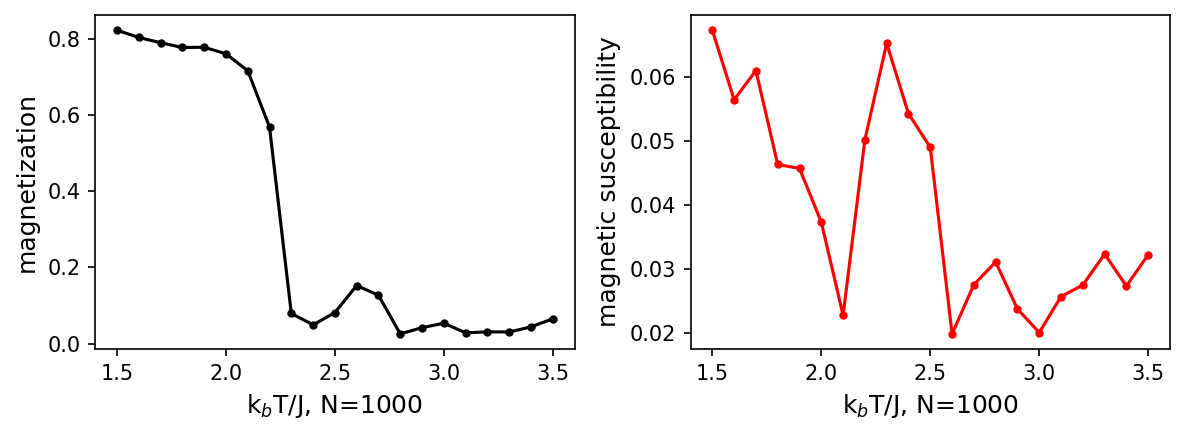

In [87]:
plt.figure(dpi=150, figsize=(8, 3))

plt.subplot(121)
plt.plot(np.linspace(1.5, 3.5, NUM_T), mags, 'k.-')
plt.xlabel(r'k$_{b}$T/J, N=1000', fontsize=12)
plt.ylabel('magnetization', fontsize=12)

plt.subplot(122)
plt.plot(np.linspace(1.5, 3.5, NUM_T), suss, 'r.-')
plt.xlabel(r'k$_{b}$T/J, N=1000', fontsize=12)
plt.ylabel('magnetic susceptibility', fontsize=12)

plt.tight_layout()
plt.show()